In [1]:
!pip install tensorflow

In [3]:
!nvidia-smi


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [6]:
# 🔧 Imports
import boto3
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [7]:
# 📥 Step 2: Load Dataset
#from google.colab import files
#uploaded = files.upload()
# S3 Config
bucket_name = 'brainwave-analysis-bucket-new'
file_key = 'synthetic_eeg_emotion_data.csv'

# Initialize S3 client
s3 = boto3.client('s3')



In [8]:
# Load CSV
#df = pd.read_csv("synthetic_eeg_emotion_data.csv")
#print("✅ Dataset Loaded")
# Fetch and Load CSV
try:
    response = s3.get_object(Bucket=bucket_name, Key=file_key)
    df = pd.read_csv(io.BytesIO(response['Body'].read()))
    print("✅ Dataset successfully loaded from S3")
    display(df.head())  # or print(df.head())
except s3.exceptions.NoSuchKey:
    print(f"❌ File not found at s3://{bucket_name}/{file_key}")

✅ Dataset successfully loaded from S3


,Subject_ID,1_Delta,1_Theta,1_Alpha,1_Beta,1_Gamma,2_Delta,2_Theta,2_Alpha,2_Beta,...,13_Alpha,13_Beta,13_Gamma,14_Delta,14_Theta,14_Alpha,14_Beta,14_Gamma,Valence,Arousal
0,1,0.5399,0.8296,0.6631,0.4824,0.5695,0.3605,0.6434,0.8585,0.1711,...,0.4961,0.4366,0.7094,0.7844,0.4019,0.7618,0.4102,0.5821,0.79,0.55
1,2,0.4564,0.3686,0.5120,0.3059,0.3508,0.3841,0.4964,0.5499,0.8012,...,0.5787,0.3590,0.4125,0.4281,0.2773,0.7945,0.4527,0.5151,0.21,0.44
2,3,0.3055,0.3129,0.3269,0.1847,0.4095,0.6390,0.5097,0.4345,0.3462,...,0.5383,0.4920,0.3452,0.5296,0.5929,0.6809,0.3067,0.5903,0.51,0.28
3,4,0.5792,0.4620,0.6501,0.7484,0.6147,0.8227,0.6425,0.3730,0.4471,...,0.5566,0.3438,0.3171,0.4874,0.3903,0.4055,0.4825,0.4717,0.89,0.82
4,5,0.4338,0.4588,0.5189,0.4950,0.3727,0.3617,0.0496,0.5937,0.5192,...,0.5654,0.5649,0.4573,0.6877,0.2665,0.4507,0.6818,0.4358,0.39,0.10


In [9]:
# 📊 Step 3: Data Overview
print(df.head())
print("\nShape:", df.shape)

# 🎯 Step 4: Feature & Target Separation
X = df.drop(['Subject_ID', 'Valence', 'Arousal'], axis=1)
y_val = df['Valence']
y_aro = df['Arousal']

   Subject_ID  1_Delta  1_Theta  1_Alpha  1_Beta  1_Gamma  2_Delta  2_Theta  \
0           1   0.5399   0.8296   0.6631  0.4824   0.5695   0.3605   0.6434   
1           2   0.4564   0.3686   0.5120  0.3059   0.3508   0.3841   0.4964   
2           3   0.3055   0.3129   0.3269  0.1847   0.4095   0.6390   0.5097   
3           4   0.5792   0.4620   0.6501  0.7484   0.6147   0.8227   0.6425   
4           5   0.4338   0.4588   0.5189  0.4950   0.3727   0.3617   0.0496   

   2_Alpha  2_Beta  ...  13_Alpha  13_Beta  13_Gamma  14_Delta  14_Theta  \
0   0.8585  0.1711  ...    0.4961   0.4366    0.7094    0.7844    0.4019   
1   0.5499  0.8012  ...    0.5787   0.3590    0.4125    0.4281    0.2773   
2   0.4345  0.3462  ...    0.5383   0.4920    0.3452    0.5296    0.5929   
3   0.3730  0.4471  ...    0.5566   0.3438    0.3171    0.4874    0.3903   
4   0.5937  0.5192  ...    0.5654   0.5649    0.4573    0.6877    0.2665   

   14_Alpha  14_Beta  14_Gamma  Valence  Arousal  
0    0.7618   0.4

In [10]:
# 🔄 Step 5: Train/Test Split
X_train, X_test, y_train_val, y_test_val = train_test_split(X, y_val, test_size=0.2, random_state=42)
_, _, y_train_aro, y_test_aro = train_test_split(X, y_aro, test_size=0.2, random_state=42)


In [11]:
# ⚙️ Step 6: Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
# 🤖 Step 7: Train Models
# ⚙️ Define MLP model builder
def build_mlp(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # Since output is in range [0,1]
    model.compile(optimizer='adam', loss='mse')
    return model

In [13]:
# 📈 Step 8: Predict and Evaluate
model_val = build_mlp(X_train_scaled.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_val = model_val.fit(
    X_train_scaled, y_train_val,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

2025-05-26 12:07:17.002363: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
# 📊 Step 9: Visualization
# 🧠 Train MLP for Arousal
model_aro = build_mlp(X_train_scaled.shape[1])
history_aro = model_aro.fit(
    X_train_scaled, y_train_aro,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

In [15]:
## 9.2 Scatter Plot - Ground Truth vs Prediction
# 📈 Evaluation
val_preds = model_val.predict(X_test_scaled).flatten()
aro_preds = model_aro.predict(X_test_scaled).flatten()

val_rmse = np.sqrt(mean_squared_error(y_test_val, val_preds))
aro_rmse = np.sqrt(mean_squared_error(y_test_aro, aro_preds))
val_r2 = r2_score(y_test_val, val_preds)
aro_r2 = r2_score(y_test_aro, aro_preds)

print(f"🧠 Valence RMSE: {val_rmse:.3f} | R²: {val_r2:.3f}")
print(f"⚡ Arousal RMSE: {aro_rmse:.3f} | R²: {aro_r2:.3f}")


1/1 [==============================] - 0s 170ms/step
🧠 Valence RMSE: 0.230 | R²: -0.468
⚡ Arousal RMSE: 0.264 | R²: -0.506


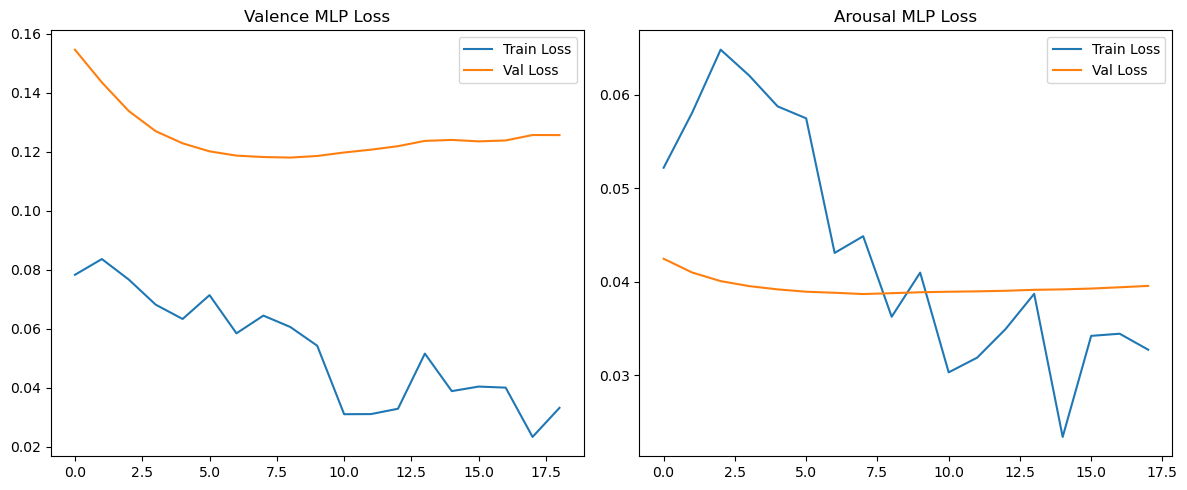

In [16]:
## 9.3 Feature Importance
# 📉 Plot Predictions
# 📊 Plot Loss Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_val.history['loss'], label='Train Loss')
plt.plot(history_val.history['val_loss'], label='Val Loss')
plt.title('Valence MLP Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_aro.history['loss'], label='Train Loss')
plt.plot(history_aro.history['val_loss'], label='Val Loss')
plt.title('Arousal MLP Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
# 📊 Assign emotion labels based on Valence-Arousal
def classify_emotion(val, aro):
    if val >= 0.5 and aro >= 0.5:
        return 'Excited'
    elif val >= 0.5 and aro < 0.5:
        return 'Relaxed'
    elif val < 0.5 and aro >= 0.5:
        return 'Angry'
    else:
        return 'Sad'

# 🧪 Apply on predicted data
emotion_df = pd.DataFrame({
    'True_Valence': y_test_val.values,
    'Pred_Valence': val_preds,
    'True_Arousal': y_test_aro.values,
    'Pred_Arousal': aro_preds,
    'Index': np.arange(len(val_preds))
})

emotion_df['Emotion'] = emotion_df.apply(lambda row: classify_emotion(row['Pred_Valence'], row['Pred_Arousal']), axis=1)


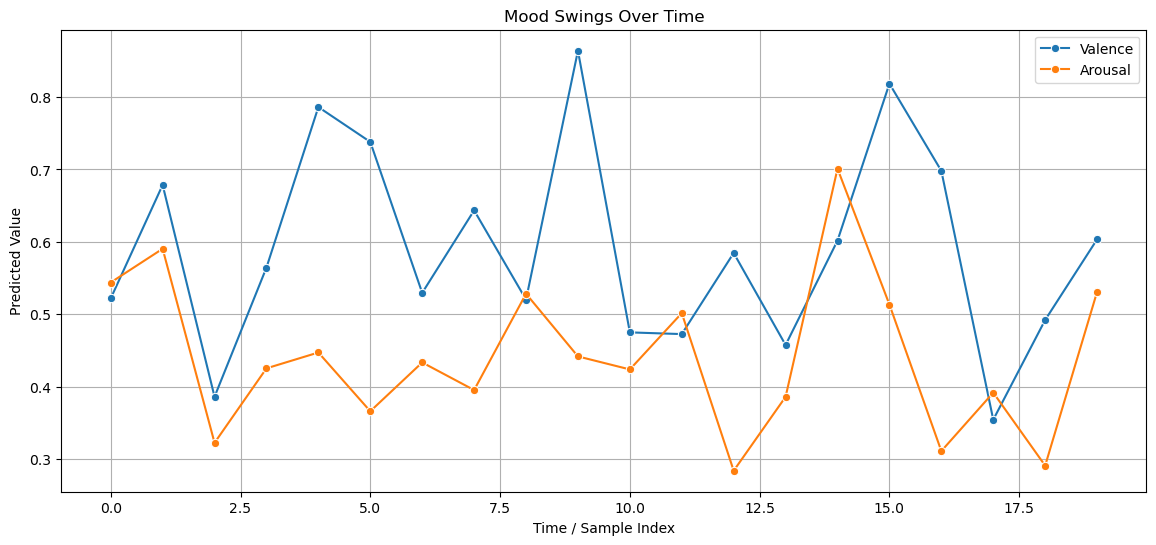

In [18]:
# 📈 Mood swings over prediction index
plt.figure(figsize=(14, 6))
sns.lineplot(x='Index', y='Pred_Valence', data=emotion_df, label='Valence', marker='o')
sns.lineplot(x='Index', y='Pred_Arousal', data=emotion_df, label='Arousal', marker='o')
plt.title("Mood Swings Over Time")
plt.xlabel("Time / Sample Index")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid(True)
plt.show()


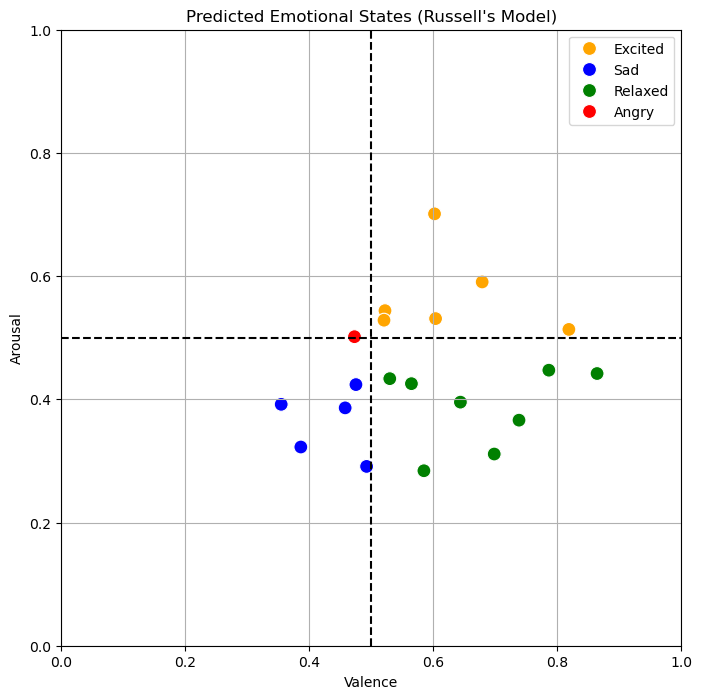

In [19]:
# 🎨 Emotion Color Map
color_map = {
    'Happy': 'gold', 'Excited': 'orange',
    'Relaxed': 'green', 'Sad': 'blue',
    'Angry': 'red', 'Neutral': 'gray'
}

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x='Pred_Valence', y='Pred_Arousal',
    hue='Emotion', data=emotion_df,
    palette=color_map, s=100
)
plt.title("Predicted Emotional States (Russell's Model)")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.axhline(0.5, linestyle='--', color='black')
plt.axvline(0.5, linestyle='--', color='black')
plt.grid(True)
plt.legend()
plt.show()
